## Structured Noise Simulations over Time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from noise import pnoise2
import matplotlib.animation as animation
from IPython.display import HTML

### Common Parameters and Functions

In [2]:
width, height = 256, 256            # Image resolution (256 = grayscale)
# m, n = 100, 100                     # Image resolution 
# t_steps = 100                       # Number of time bins (distribution over time)

m, n = 30, 30                       # Image resolution 
t_steps = 30                        # Number of time bins (distribution over time)

In [3]:
# Plots Distribution of pixel_x and pixel_y over time
def get_distribution(time, pixel_distribution, pixel_x, pixel_y):
    plt.figure(figsize=(8, 5))
    plt.plot(time, pixel_distribution, marker='o', linestyle='-', color='b')
    plt.xlabel("Time")
    plt.ylabel("Intensity (Normalized)")
    plt.title(f"Time Distribution at Pixel ({pixel_x}, {pixel_y})")
    plt.grid()
    plt.show()

In [4]:
# Plots moving distribution of overall image over time
def animated_plot(time_distribution, time_steps):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Initial plot
    im = ax.imshow(time_distribution[0, :, :], cmap='hot', extent=[0, 100, 0, 100])
    ax.set_xlabel("X Pixels")
    ax.set_ylabel("Y Pixels")
    ax.set_title("Simulation")

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, label="Light Intensity")

    # Update function for animation
    def update(frame):
        im.set_array(time_distribution[:, :, frame])  # Update the plot with new time slice
        ax.set_title(f"Simulation at Time {frame}")
        return [im]

    # Animation
    ani = animation.FuncAnimation(fig, update, frames=range(time_steps), interval=100, blit=True)
    return ani

## Monte Carlo Ray Tracing (MCRT) Noise Distribution

In [5]:
num_rays = 500000                   # Total number of rays to simulate

light_position = (15, 15)           # Light source at the center
circle_center = (15, 15)            # Circle at the center (reflective surface)
circle_radius = 7                  # Radius of the circle

In [6]:
# Define simple ray tracing function that calculates light intensity at each pixel
def trace_ray(x, y, light_pos, circle_center, circle_radius):
    # Calculate the distance from the pixel to the light source
    distance_to_light = np.sqrt((x - light_pos[0]) ** 2 + (y - light_pos[1]) ** 2)
    
    # Calculate distance to circle center (assume a perfect circular reflective surface)
    distance_to_circle = np.sqrt((x - circle_center[0]) ** 2 + (y - circle_center[1]) ** 2)
    
    # If the pixel is within the circle, we simulate reflection (for simplicity, use 1 as full reflection)
    if distance_to_circle <= circle_radius:
        intensity = 1.0 / distance_to_light  # Inverse distance attenuation
    else:
        intensity = 0  # No light if outside the circle
    
    return intensity

In [7]:
# Create the time distribution (light intensities over time)
def create_time_distribution(width, height, time_steps):
    time_distribution = np.zeros((time_steps, height, width))
    
    for time in range(time_steps):
        for x in range(width):
            for y in range(height):
                # Simulate light intensity at each pixel using the ray tracing function
                intensity = trace_ray(x, y, light_position, circle_center, circle_radius)
                # We can add some time-based variation (e.g., light flicker or pulsation)
                time_distribution[y, x, time] = intensity * (1 + 0.2 * np.sin(time / 10.0))  # Simple variation
    
    return time_distribution

In [8]:
# Create time distribution (light intensities over time)
circle_distribution = create_time_distribution(m, n, t_steps)

/var/folders/vn/9n4mdvbj54lbr8ffl0577zgw0000gn/T/ipykernel_83556/2820115355.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  intensity = 1.0 / distance_to_light  # Inverse distance attenuation


/var/folders/vn/9n4mdvbj54lbr8ffl0577zgw0000gn/T/ipykernel_83556/2362462377.py:2: RuntimeWarning: invalid value encountered in divide
  norm_img_distribution = circle_distribution / np.max(circle_distribution)
/var/folders/vn/9n4mdvbj54lbr8ffl0577zgw0000gn/T/ipykernel_83556/2362462377.py:9: RuntimeWarning: divide by zero encountered in divide
  pixel_distribution = (circle_distribution[idx, idx, :] - np.mean(circle_distribution[idx, idx, :])) / np.std(circle_distribution[idx, idx, :])
/var/folders/vn/9n4mdvbj54lbr8ffl0577zgw0000gn/T/ipykernel_83556/2362462377.py:9: RuntimeWarning: invalid value encountered in divide
  pixel_distribution = (circle_distribution[idx, idx, :] - np.mean(circle_distribution[idx, idx, :])) / np.std(circle_distribution[idx, idx, :])


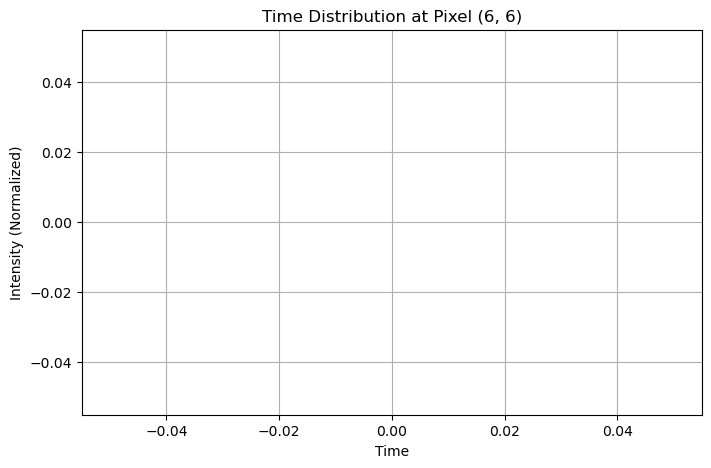

In [9]:
# Normalize the time distribution for visualization
norm_img_distribution = circle_distribution / np.max(circle_distribution)

# Define time bins
time_bins =  np.linspace(0, t_steps, t_steps)

# Choose a single pixel for visualization (example: center of the image)
idx = 6
pixel_distribution = (circle_distribution[idx, idx, :] - np.mean(circle_distribution[idx, idx, :])) / np.std(circle_distribution[idx, idx, :])

get_distribution(time_bins, pixel_distribution, idx, idx)

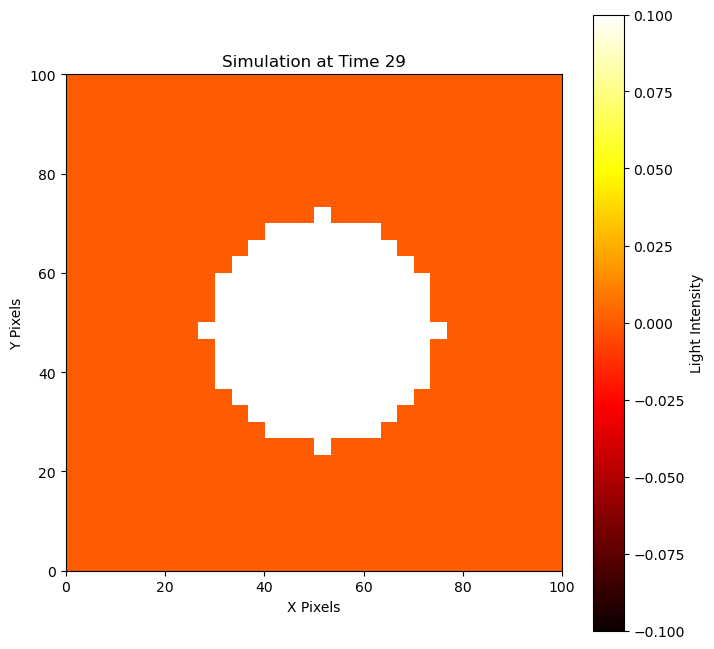

In [10]:
circle_ani = animated_plot(circle_distribution, t_steps)

HTML(circle_ani.to_jshtml())

## Random Gaussian Noise Distribution

In [11]:
def get_random_distrubution(t_steps):    
    # Create an array to store the image sequence
    random_distribution = np.zeros((m, n, t_steps))

    # Generate images over time
    for t in range(t_steps):
        # Simulate some Gaussian noise with time-varying properties
        random_distribution[:, :, t] = np.random.normal(loc=0.5, scale=0.1 + 0.05 * np.sin(t / 5.0), size=(m, n))
    return random_distribution

In [12]:
random_distribution = get_random_distrubution(t_steps)

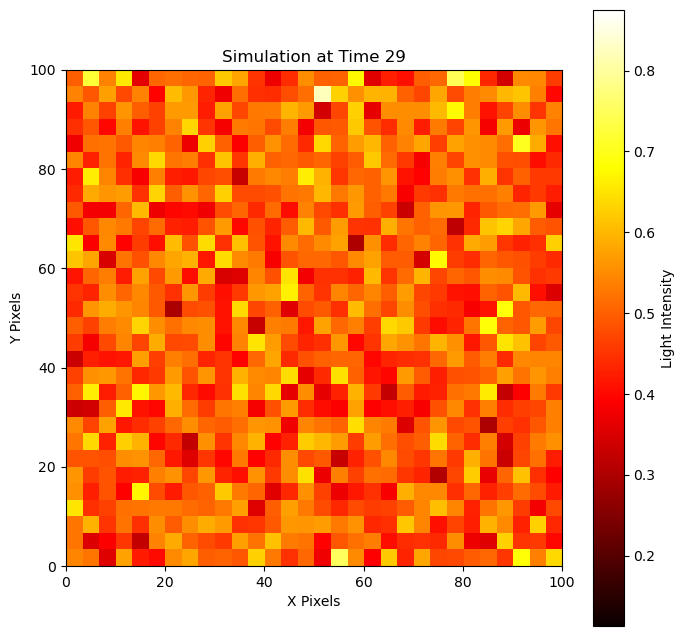

In [13]:
random_ani = animated_plot(random_distribution, t_steps)

HTML(random_ani.to_jshtml())

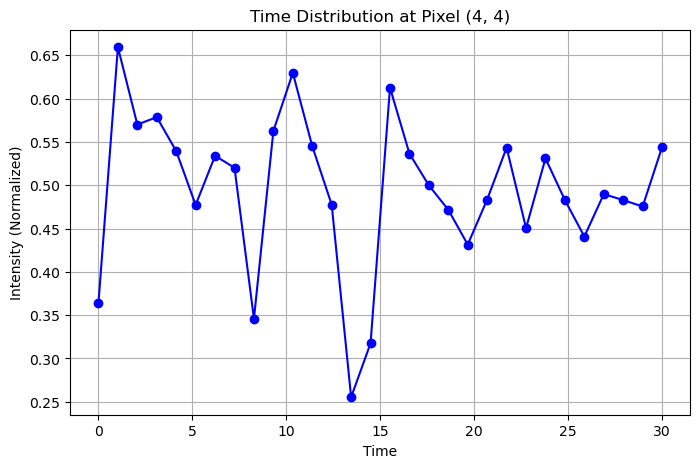

In [14]:
idx_2 = 4
get_distribution(time_bins, random_distribution[idx_2, idx_2, :], idx_2, idx_2)

## Perlin Noise Distribution

In [15]:
scale = 10        # Scale of the Perlin noise
octaves = 6       # Perlin noise octaves
persistence = 0.5 # Persistence for Perlin noise
lacunarity = 2.0  # Lacunarity for Perlin noise

In [16]:
# Generate structured noisy image using Perlin noise
def generate_perlin_noise_image(t, size=(m, n), scale=10, octaves=6, persistence=0.5, lacunarity=2.0):
    image = np.zeros(size)
    
    # Generate Perlin noise for each pixel
    for i in range(size[0]):
        for j in range(size[1]):
            # Calculate Perlin noise value for the given pixel location
            noise_value = pnoise2(i / scale, j / scale, octaves=octaves,
                                  persistence=persistence, lacunarity=lacunarity,
                                  repeatx=1024, repeaty=1024, base=t)
            # Normalize and add to the image
            image[i, j] = noise_value
            
    return image

In [17]:
def get_perlin_distribution():
    # Initialize a 3D array to store image sequence (m, n, t_steps)
    perlin_distribution = np.zeros((m, n, t_steps))

    # Generate images over time with evolving noise
    for t in range(t_steps):
        # Generate structured noisy image for the current time step
        noise_image = generate_perlin_noise_image(t)
        
        # Normalize the image to ensure pixel values are between 0 and 1
        perlin_distribution[:, :, t] = np.clip(noise_image, -1, 1)
    return perlin_distribution

In [18]:
perlin_distribution = get_perlin_distribution()

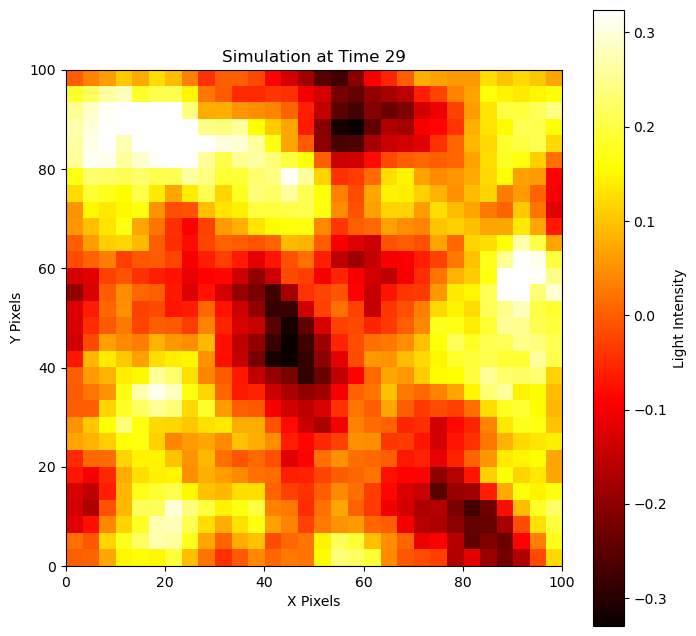

In [19]:
perlin_ani = animated_plot(perlin_distribution, t_steps)

HTML(perlin_ani.to_jshtml())

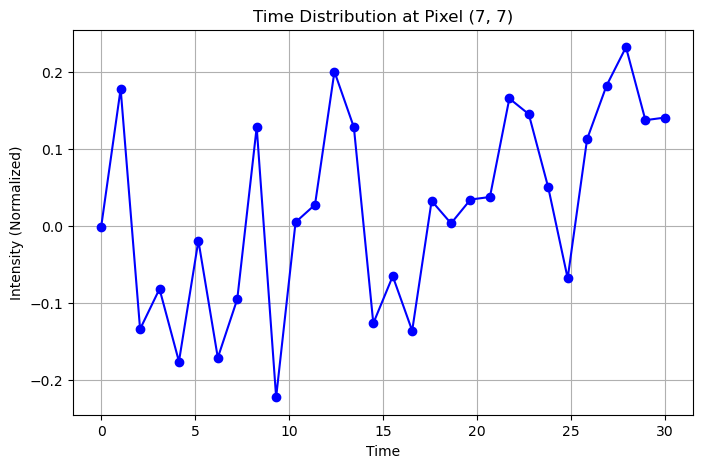

In [20]:
idx_3 = 7
get_distribution(time_bins, perlin_distribution[idx_3, idx_3, :], idx_3, idx_3)

# Denoiser Diffusion Model

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [22]:
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet3D, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Conv3d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid(),  # Output should be normalized between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [23]:
# Define the noise schedule
def create_noise_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    betas = torch.linspace(beta_start, beta_end, timesteps)
    alpha = 1 - betas
    alpha_cumprod = torch.cumprod(alpha, dim=0)
    return betas, alpha, alpha_cumprod

class DiffusionModel:
    def __init__(self, model, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.model = model
        self.timesteps = timesteps
        self.betas, self.alpha, self.alpha_cumprod = create_noise_schedule(timesteps, beta_start, beta_end)

    def forward_diffusion(self, x0, t):
        """Adds noise to the image over time"""
        noise = torch.randn_like(x0)
        noisy_image = torch.sqrt(self.alpha_cumprod[t]) * x0 + torch.sqrt(1 - self.alpha_cumprod[t]) * noise
        return noisy_image, noise

    def reverse_diffusion(self, noisy_image, t):
        """Uses the model to predict the noise and denoise the image"""
        return self.model(noisy_image)

In [24]:
class NoisyTemporalDataset(Dataset):
    def __init__(self, clean_data, noise_level=0.1):
        """
        Args:
            clean_data (torch.Tensor): Clean dataset of shape (num_samples, m, n, t)
            noise_level (float): Standard deviation of Gaussian noise
        """
        if isinstance(clean_data, np.ndarray):
            clean_data = torch.tensor(clean_data, dtype=torch.float32)
            
        self.clean_data = clean_data  # Shape: (num_samples, m, n, t)
        self.noise_level = noise_level

    def __len__(self):
        return self.clean_data.shape[0]

    def __getitem__(self, idx):
        clean_sample = self.clean_data[idx]  # Shape: (m, n, t)
        
        # Add Gaussian noise (forward diffusion step)
        noise = torch.randn_like(clean_sample) * self.noise_level
        noisy_sample = clean_sample + noise
        
        return noisy_sample, clean_sample  # Return noisy input & clean target

In [25]:
samples = 25
dist_data = np.zeros((samples, m, n, t_steps))

for i in range(samples):
    # dist_data[i, :, :, :] = get_random_distrubution(t_steps)
    dist_data[i, :, :, :] = get_perlin_distribution()
    # dist_data[i, :, :, :] = create_time_distribution(m, n, t_steps)

In [26]:
dataset = NoisyTemporalDataset(dist_data, noise_level=0.05)
dataloader = DataLoader(dataset, batch_size=6, shuffle=True)

In [27]:
# Define the training procedure
def train_model(model, dataloader, num_epochs=10, learning_rate=1e-3):
    """
    Trains the 3D U-Net denoising model in a self-supervised manner.
    """
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()  # Mean Squared Error for denoising task

    for epoch in range(num_epochs):
        running_loss = 0.0
        for noisy_batch, clean_batch in dataloader:
            optimizer.zero_grad()
            
            # Add an extra channel dimension for 3D CNN (batch, channels, m, n, t)
            noisy_batch = noisy_batch.unsqueeze(1)
            clean_batch = clean_batch.unsqueeze(1)

            # Forward pass
            predicted_clean = model(noisy_batch)

            # Compute loss (compare predicted denoised image to ground truth)
            loss = criterion(predicted_clean, clean_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(dataloader)}")

In [28]:
model = UNet3D(in_channels=1, out_channels=1)

In [29]:
train_model(model, dataloader)

Epoch 1/10, Loss: 0.0726751808077097
Epoch 2/10, Loss: 0.021406843885779382
Epoch 3/10, Loss: 0.021406843885779382


KeyboardInterrupt: 

In [ ]:
def test_model(model, dataset, num_samples=20):
    """
    Tests the model by denoising and visualizing random samples from the dataset.
    """
    model.eval()

    noisy_data = []
    denoised_data = []
    clean_data = []

    with torch.no_grad():
        for i in range(num_samples):
            noisy_image, clean_image = dataset[i]  # Get one sample

            # Add extra channel dimension for the model
            noisy_image_2 = noisy_image.unsqueeze(0).unsqueeze(0)  # (1, 1, m, n, t)
            denoised_image = model(noisy_image_2).squeeze(0).squeeze(0)  # Remove extra dims

            # Visualize results
            noisy_data.append(noisy_image)
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(noisy_image.squeeze(0).cpu().numpy()[:, :, 0], cmap='hot')
            plt.title(f"Noisy Image (t={i})")
            plt.colorbar()

            denoised_data.append(denoised_image)
            plt.subplot(1, 3, 2)
            plt.imshow(denoised_image.cpu().numpy()[:, :, 0], cmap='hot')
            plt.title(f"Denoised Image (t={i})")
            plt.colorbar()

            clean_data.append(clean_image)
            plt.subplot(1, 3, 3)
            plt.imshow(clean_image.cpu().numpy()[:, :, 0], cmap='hot')
            plt.title(f"Ground Truth (t={i})")
            plt.colorbar()

            plt.show()

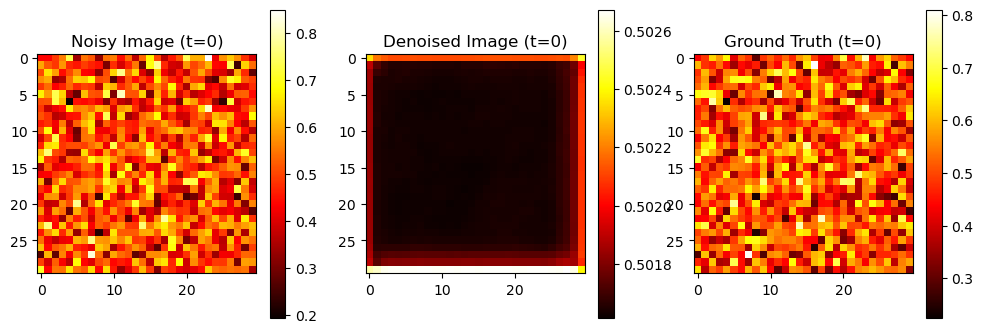

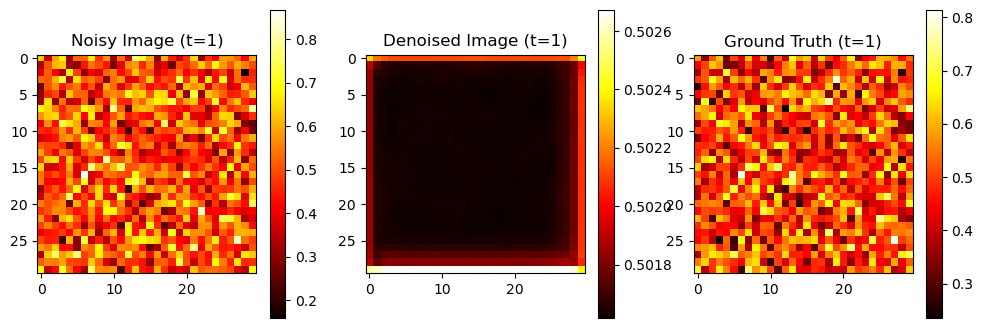

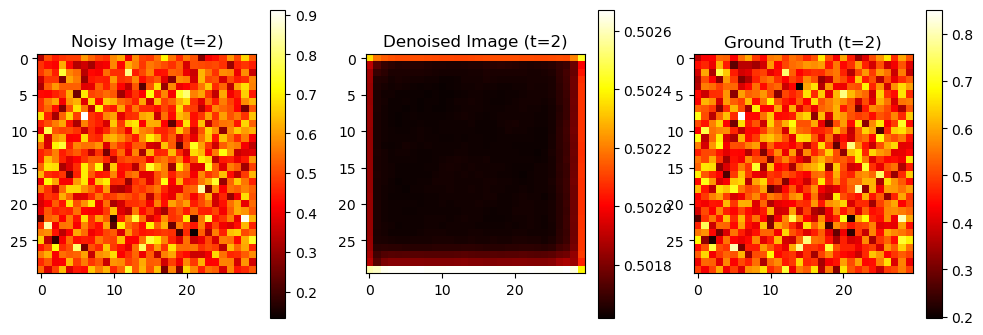

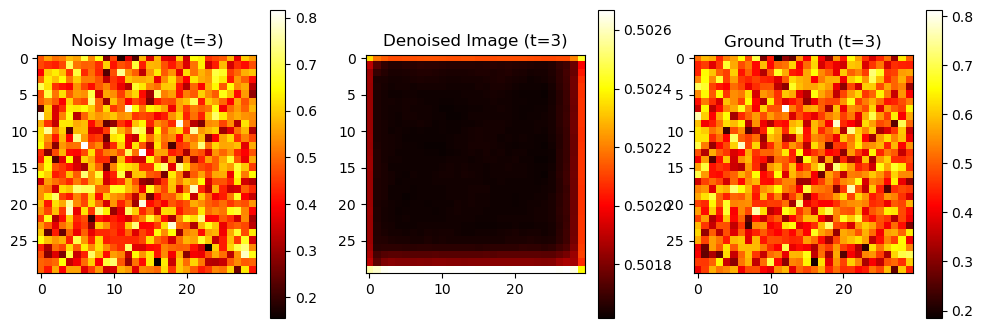

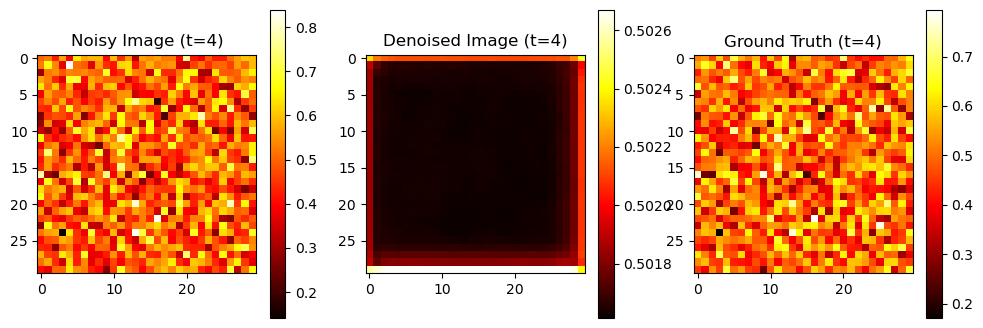

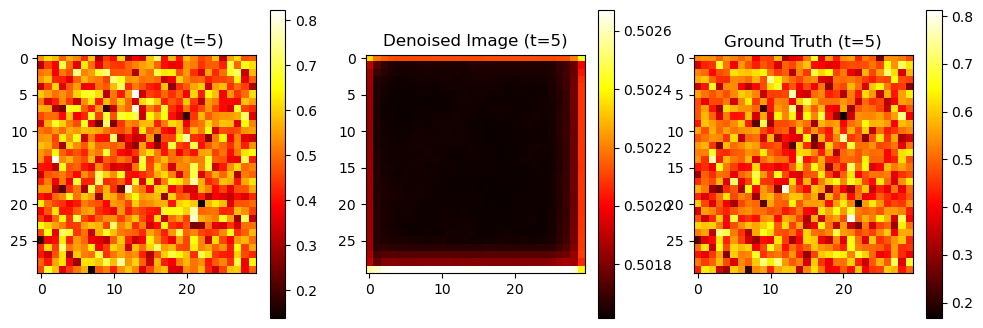

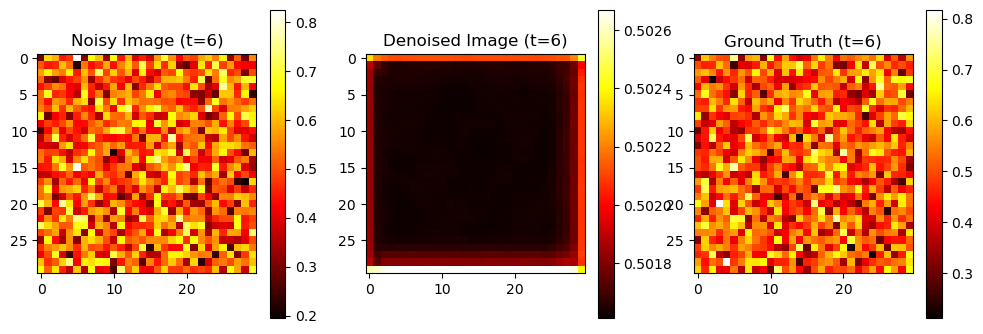

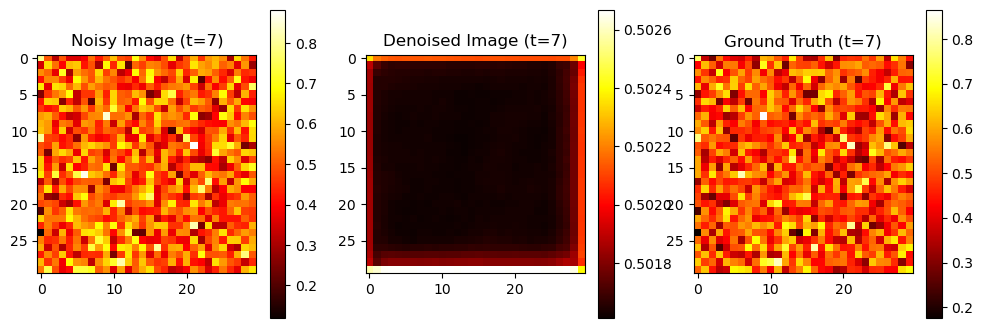

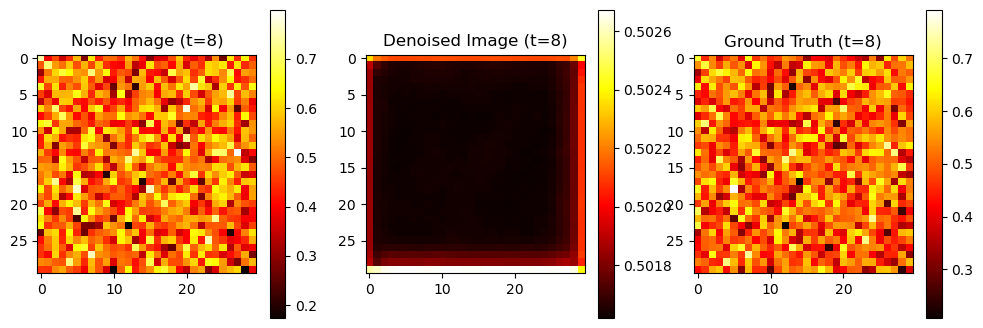

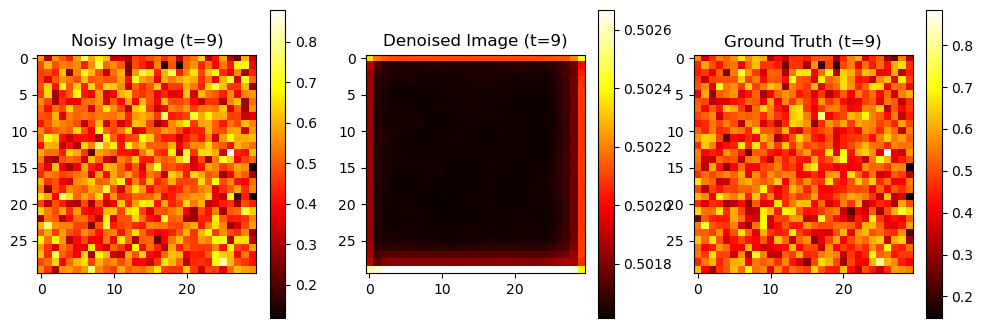

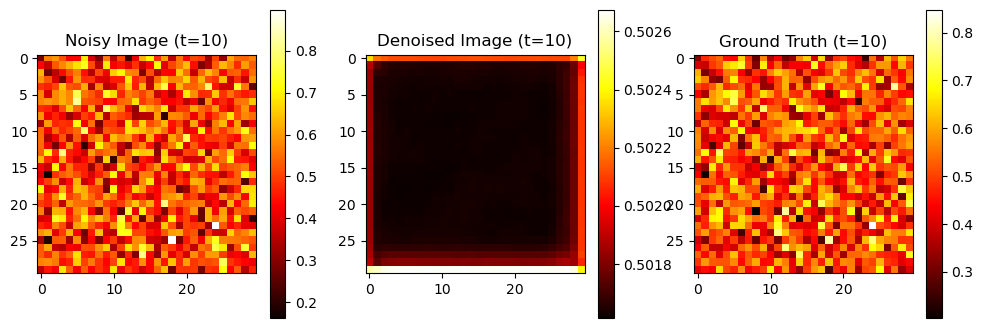

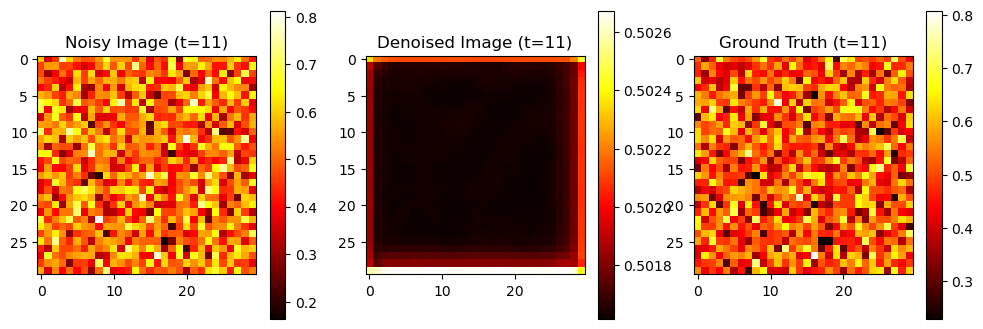

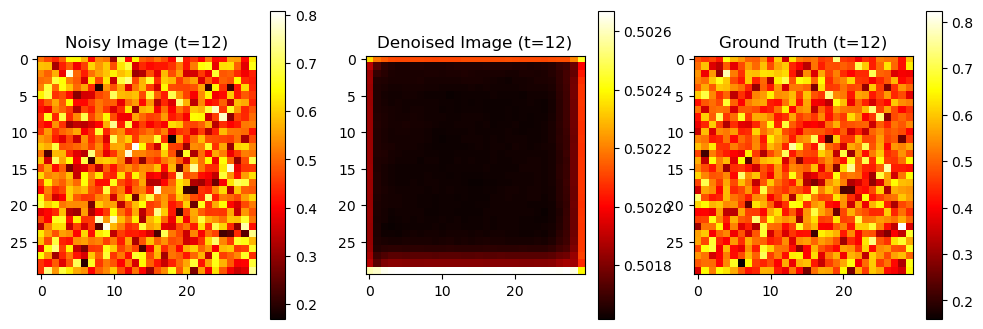

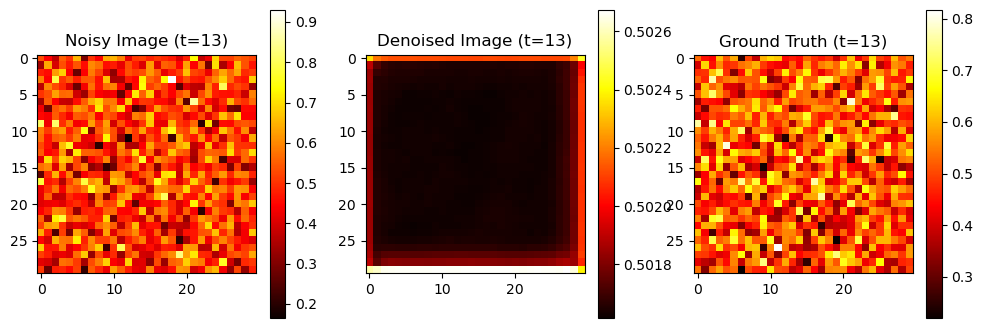

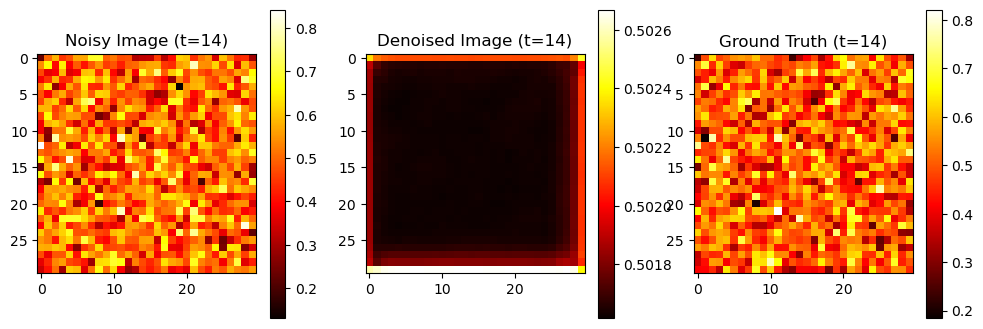

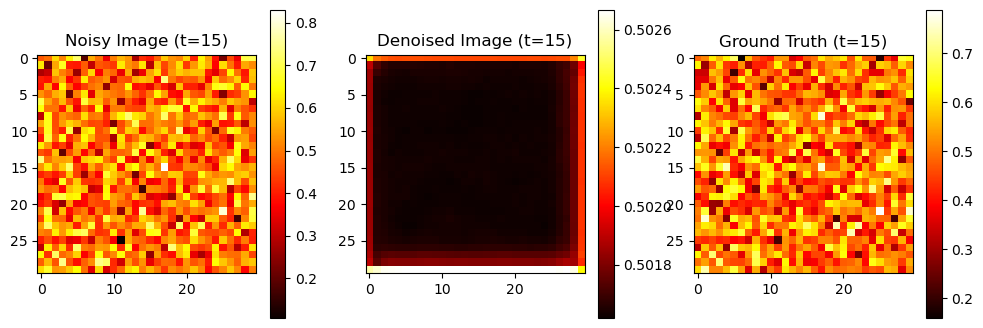

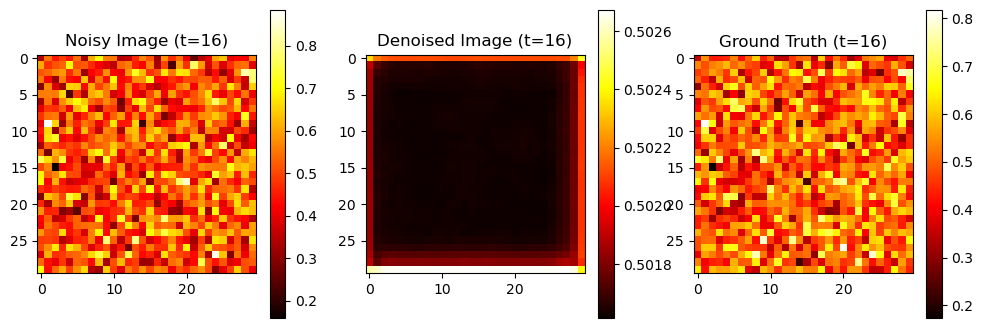

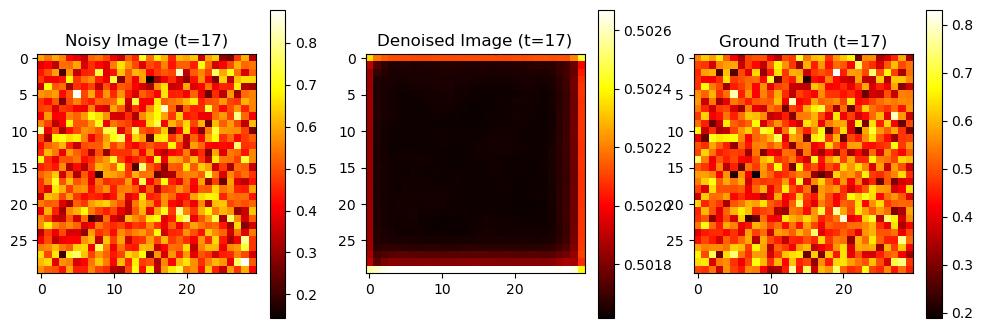

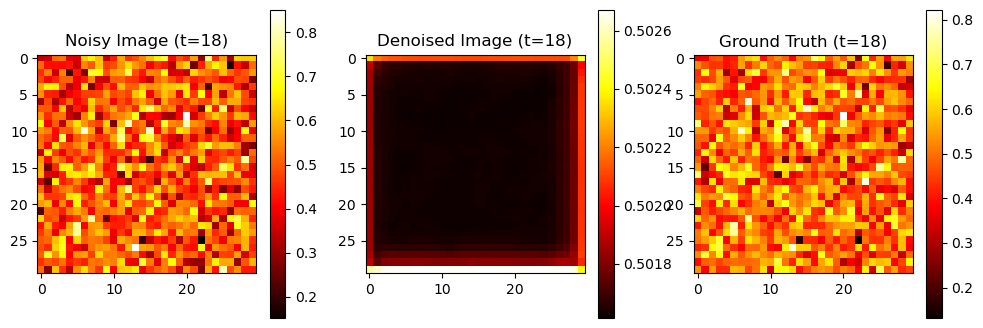

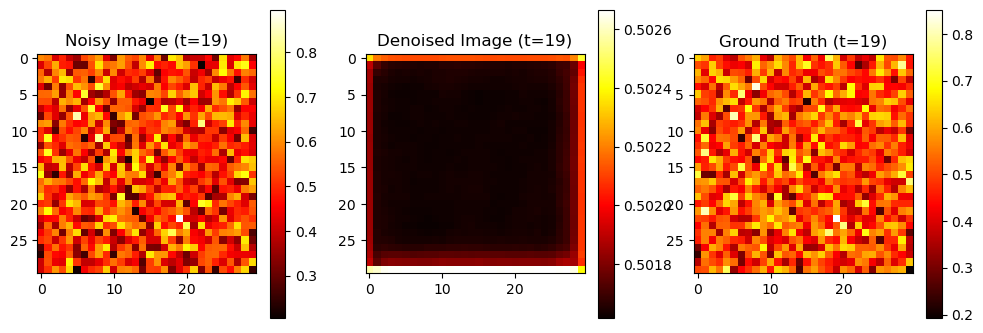

In [ ]:
test_model(model, dataset)

**Note**: data at each tie t should not be independent but also consider image at previous time step!